**Chapter 7 – Ensemble Learning and Random Forests**

_This notebook contains all the sample code and solutions to the exercises in chapter 7._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting Classifiers (투표 기반 분류기)

동일한 데이터셋으로 서로 다른 알고리즘을 훈련 후 예측(클래스 또는 확률)을 취합

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)    # test_size = 0.25 by default

**Note**: to be future-proof, we set `solver="lbfgs"`, `n_estimators=100`, and `gamma="scale"` since these will be the default values in upcoming Scikit-Learn versions.

Hard voting:

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [4]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Soft voting:

In [6]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42) # "probability=True" is required to get probability
#svm_clf = SVC(gamma="scale", random_state=42)                 
# if we omit the option an error occurs in the next cell

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging and Pasting (배깅과 페이스팅)

서로 다른 데이터셋으로 동일 알고리즘을 훈련 후 예측(클래스 또는 확률)을 취합<br>
서로 다른 훈련 데이터셋은 랜덤 샘플링으로 생성<br>
- 배깅: 복원 추출(sampling with replacement) --> 중복 샘플 허용<br>
- 페이스팅: 비복원 추출(sampling without replacement) --> 중복 샘플 비허용<br>

## Bagging and Pasting in Scikit-Learn

In [8]:
####################################################################################################
# 배깅으로 500개의 의사결정나무 분류기를 포함하는 앙상블 모델 훈련
####################################################################################################
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,         # All 500 estimators are the same algorithm (DecisionTreeClassifier)
    max_samples=100, bootstrap=True, random_state=42,   # Sampling 100 instances with replacement (bootstrap=True)
    #max_samples=100, bootstrap=False, random_state=42,   # Sampling 100 instances without replacement (bootstrap=False)
    verbose=2)
bag_clf.fit(X_train, y_train)

Building estimator 1 of 500 for this parallel run (total 500)...
Building estimator 2 of 500 for this parallel run (total 500)...
Building estimator 3 of 500 for this parallel run (total 500)...
Building estimator 4 of 500 for this parallel run (total 500)...
Building estimator 5 of 500 for this parallel run (total 500)...
Building estimator 6 of 500 for this parallel run (total 500)...
Building estimator 7 of 500 for this parallel run (total 500)...
Building estimator 8 of 500 for this parallel run (total 500)...
Building estimator 9 of 500 for this parallel run (total 500)...
Building estimator 10 of 500 for this parallel run (total 500)...
Building estimator 11 of 500 for this parallel run (total 500)...
Building estimator 12 of 500 for this parallel run (total 500)...
Building estimator 13 of 500 for this parallel run (total 500)...
Building estimator 14 of 500 for this parallel run (total 500)...
Building estimator 15 of 500 for this parallel run (total 500)...
Building estimator 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 18 of 500 for this parallel run (total 500)...
Building estimator 19 of 500 for this parallel run (total 500)...
Building estimator 20 of 500 for this parallel run (total 500)...
Building estimator 21 of 500 for this parallel run (total 500)...
Building estimator 22 of 500 for this parallel run (total 500)...
Building estimator 23 of 500 for this parallel run (total 500)...
Building estimator 24 of 500 for this parallel run (total 500)...
Building estimator 25 of 500 for this parallel run (total 500)...
Building estimator 26 of 500 for this parallel run (total 500)...
Building estimator 27 of 500 for this parallel run (total 500)...
Building estimator 28 of 500 for this parallel run (total 500)...
Building estimator 29 of 500 for this parallel run (total 500)...
Building estimator 30 of 500 for this parallel run (total 500)...
Building estimator 31 of 500 for this parallel run (total 500)...
Building estimator 32 of 500 for this parallel run (total 500)...
Building e

Building estimator 194 of 500 for this parallel run (total 500)...
Building estimator 195 of 500 for this parallel run (total 500)...
Building estimator 196 of 500 for this parallel run (total 500)...
Building estimator 197 of 500 for this parallel run (total 500)...
Building estimator 198 of 500 for this parallel run (total 500)...
Building estimator 199 of 500 for this parallel run (total 500)...
Building estimator 200 of 500 for this parallel run (total 500)...
Building estimator 201 of 500 for this parallel run (total 500)...
Building estimator 202 of 500 for this parallel run (total 500)...
Building estimator 203 of 500 for this parallel run (total 500)...
Building estimator 204 of 500 for this parallel run (total 500)...
Building estimator 205 of 500 for this parallel run (total 500)...
Building estimator 206 of 500 for this parallel run (total 500)...
Building estimator 207 of 500 for this parallel run (total 500)...
Building estimator 208 of 500 for this parallel run (total 500

Building estimator 386 of 500 for this parallel run (total 500)...
Building estimator 387 of 500 for this parallel run (total 500)...
Building estimator 388 of 500 for this parallel run (total 500)...
Building estimator 389 of 500 for this parallel run (total 500)...
Building estimator 390 of 500 for this parallel run (total 500)...
Building estimator 391 of 500 for this parallel run (total 500)...
Building estimator 392 of 500 for this parallel run (total 500)...
Building estimator 393 of 500 for this parallel run (total 500)...
Building estimator 394 of 500 for this parallel run (total 500)...
Building estimator 395 of 500 for this parallel run (total 500)...
Building estimator 396 of 500 for this parallel run (total 500)...
Building estimator 397 of 500 for this parallel run (total 500)...
Building estimator 398 of 500 for this parallel run (total 500)...
Building estimator 399 of 500 for this parallel run (total 500)...
Building estimator 400 of 500 for this parallel run (total 500

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, random_state=42, verbose=2)

##### sklearn.ensemble.BaggingClassifier
class sklearn.ensemble.BaggingClassifier(base_estimator=None, n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)<br>
A Bagging classifier.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html?highlight=baggingclassifier#sklearn.ensemble.BaggingClassifier<br>

In [9]:
####################################################################################################
# 배깅으로 훈련한 앙상블 모델의 성능(정확도) 측정
####################################################################################################
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [10]:
####################################################################################################
# 의사결정나무 1개를 훈련 후 성능 측정
# --------------------------------------------------------------------------------------------------
# 1개의 의사결정나무보다 500개의 의사결정나무를 포함하는 앙상블 모델의 성능이 우수
####################################################################################################
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [11]:
####################################################################################################
# 앙상블 모델에 포함된 500개의 의사결정나무 확인
####################################################################################################
bag_clf.estimators_

[DecisionTreeClassifier(random_state=1952926171),
 DecisionTreeClassifier(random_state=1761383086),
 DecisionTreeClassifier(random_state=1449071958),
 DecisionTreeClassifier(random_state=1910541088),
 DecisionTreeClassifier(random_state=1341730541),
 DecisionTreeClassifier(random_state=1286572245),
 DecisionTreeClassifier(random_state=1005142668),
 DecisionTreeClassifier(random_state=502852014),
 DecisionTreeClassifier(random_state=186414760),
 DecisionTreeClassifier(random_state=1956263048),
 DecisionTreeClassifier(random_state=15592051),
 DecisionTreeClassifier(random_state=1628376228),
 DecisionTreeClassifier(random_state=1638437331),
 DecisionTreeClassifier(random_state=116435712),
 DecisionTreeClassifier(random_state=588556688),
 DecisionTreeClassifier(random_state=358068376),
 DecisionTreeClassifier(random_state=67998415),
 DecisionTreeClassifier(random_state=825108120),
 DecisionTreeClassifier(random_state=1237545031),
 DecisionTreeClassifier(random_state=1708477288),
 DecisionT

In [12]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choos

In [13]:
####################################################################################################
# 앙상블 모델 속 500개의 의사결정나무 각각에 대한 훈련 데이터 확인
####################################################################################################
bag_clf.estimators_samples_

[array([ 41, 332, 130, 231,  92, 199, 370, 120,  28, 233,  84,   6, 324,
        338, 307, 105,  74, 290, 349, 260, 290,   8, 288,  59,  95,   3,
        150, 363, 302, 116, 194, 361,  77, 184, 336, 242, 241, 213,  64,
        256,  59, 103, 337,  41, 347,  70, 132, 256,  60, 279,  14, 234,
        249, 183, 203, 301, 340, 165, 100, 173, 213, 367,  23,  70,   1,
        337, 172, 294, 353, 367, 371,  52,   9, 338, 327, 109,  73, 372,
        217, 196,  14, 288, 104, 299, 104,  45, 357,  53, 261, 370, 146,
         36, 303, 279, 340, 240, 352,  39, 120, 292]),
 array([174, 151, 279,  31, 357, 234,   3, 303, 202,  83, 200, 163, 109,
        355, 104,  72, 274,  71, 249, 346, 117, 219,  51, 314,  75, 250,
         87, 184, 363,  16, 227, 341,  84, 227, 347,   7, 244, 193,  72,
          3, 131, 177, 317,  45,  31, 182, 226,  84, 171, 239, 258, 265,
        178, 313, 315, 119,  39, 184, 334,  53, 189, 139,  87, 193, 113,
         17, 297, 152, 119,  12, 121,  50, 339, 359, 225, 315,  55, 3

In [14]:
####################################################################################################
# 앙상블 모델의 의사결정나무 훈련 데이터에는 중복 샘플이 존재함을 확인
####################################################################################################
import pandas as pd
sample = bag_clf.estimators_samples_[0]
pd.DataFrame(sample).value_counts()

213    2
256    2
120    2
290    2
288    2
      ..
130    1
116    1
109    1
105    1
372    1
Length: 84, dtype: int64

**Code to generate Figure 7–5. A single Decision Tree (left) versus a bagging ensemble of 500 trees (right):**

In [15]:
####################################################################################################
# 분류 모형의 결정경계를 plot하기 위한 사용자 정의 함수
# --------------------------------------------------------------------------------------------------
# 분류기(classifier), X/y와 이 분류기의 예측값을 표현할 영역(x, y축)을 전달하면, X/y와 함께 클래스 별로 영역을 표시
# * 코드를 모두 이해하실 필요는 없으며, 함수로 전달되는 매개변수와 이 함수의 수행결과를 연계하여 
#   함수가 수행하는 작업에 대해서만 이해하고, 추후에 코드를 재활용하실 수 있으면 됩니다.
####################################################################################################
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Saving figure decision_tree_without_and_with_bagging_plot


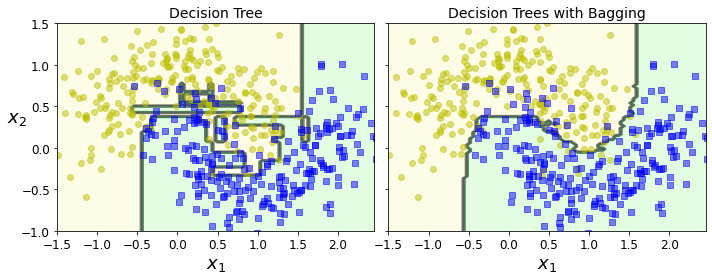

In [16]:
####################################################################################################
# 분류 모형의 결정경계를 plot
# --------------------------------------------------------------------------------------------------
# 의사결정나무 1개의 결정경계보다 의사결정나무 500개의 배깅 앙상블의 결정경계가 더 선명하게 나타남을 확인
####################################################################################################
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Out-of-Bag evaluation (oob 평가)

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a BaggingClassifier samples m training instances with replacement (bootstrap = True), where m is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor. 6 The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors.

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (Kindle Locations 4149-4155). O'Reilly Media. Kindle Edition. 

배깅 사용 시, 중복 추출을 허용하면 단 한 번도 추출되지 않는 샘플이 존재.<br>
이 샘플들을 oob(out of bag) 샘플이라 하며, 성능 평가에 사용할 수 있음.<br>
이 때의 성능은 테스트셋과 유사한 수준으로 기대할 수 있음.<br>

In [17]:
####################################################################################################
# 의사결정나무 500개를 포함하는 배깅 앙상블 모델을 훈련 후 oob 평가
# --------------------------------------------------------------------------------------------------
# bootstrap=True: 배깅인 경우에만 oob 생성됨
# oob_score=True: oob 성능을 확인하기 위해 설정 필요
####################################################################################################
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [18]:
####################################################################################################
# 의사결정나무 500개를 포함하는 배깅 앙상블 모델을 훈련 후 oob 샘플 각각에 대한 decision function 확인
####################################################################################################
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [19]:
####################################################################################################
# 의사결정나무 500개를 포함하는 배깅 앙상블 모델을 훈련 후, 테스트셋을 통한 성능 확인
####################################################################################################
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

# Random Forests (랜덤 포레스트)

In [20]:
####################################################################################################
# 의사결정나무 500개(최대 리프 노드 16개)를 포함하는 랜덤 포레스트 분류기 생성 및 훈련
####################################################################################################
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

##### sklearn.ensemble.RandomForestClassifier
class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)<br>
A random forest classifier.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier<br>

A Random Forest is equivalent to a bag of decision trees:

In [21]:
####################################################################################################
# 의사결정나무 500개(최대 리프 노드 16개)를 포함하는 배깅 앙상블 모델을 생성
####################################################################################################
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [22]:
####################################################################################################
# 두 모델의 예측 결과가 동일함을 확인
####################################################################################################
np.sum(y_pred == y_pred_rf) / len(y_pred)

1.0

In [23]:
####################################################################################################
# 두 모델의 예측 결과가 동일함을 확인
####################################################################################################
np.c_[y_pred[:10], y_pred_rf[:10]]

array([[0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]])

## Extra Tree (Extremely Randomized Trees, 엑스트라 트리)

In [24]:
####################################################################################################
# 의사결정나무 500개(최대 리프 노드 16개)를 포함하는 엑스트라 트리 분류기 생성 및 훈련
####################################################################################################
from sklearn.ensemble import ExtraTreesClassifier

xt_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
xt_clf.fit(X_train, y_train)

y_pred_xt = xt_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_rf))
print(accuracy_score(y_test, y_pred_xt))

0.912
0.912


In [25]:
np.c_[y_pred_rf, y_pred_xt]

array([[0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0,

## Feature Importance (특성 중요도)

In [26]:
####################################################################################################
# 랜덤 포레스트에서 각 특성의 중요도를 측정
####################################################################################################
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
#for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
#    print(name, score)
zipped = zip(iris["feature_names"], rnd_clf.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for name, score in zipped:
    print(name, score)

petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682
sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033


The following figure overlays the decision boundaries of 15 decision trees. As you can see, even though each decision tree is imperfect, the ensemble defines a pretty good decision boundary:

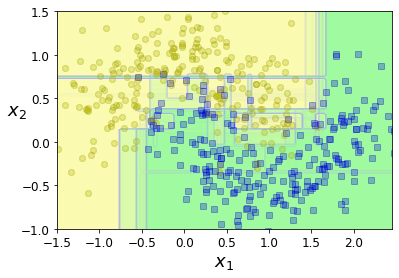

In [27]:
####################################################################################################
# 이 코드셀의 내용은 무시해도 됩니다.
####################################################################################################
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

**Code to generate Figure 7–6. MNIST pixel importance (according to a Random Forest classifier):**

In [28]:
####################################################################################################
# 이 코드셀의 내용은 무시해도 됩니다.
####################################################################################################
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [29]:
####################################################################################################
# 이 코드셀의 내용은 무시해도 됩니다.
####################################################################################################
# Let's check the type of mnist and its contents
type(mnist), mnist

(sklearn.utils.Bunch,
 {'data': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'target': array([5, 0, 4, ..., 4, 5, 6], dtype=uint8),
  'frame': None,
  'categories': {},
  'feature_names': ['pixel1',
   'pixel2',
   'pixel3',
   'pixel4',
   'pixel5',
   'pixel6',
   'pixel7',
   'pixel8',
   'pixel9',
   'pixel10',
   'pixel11',
   'pixel12',
   'pixel13',
   'pixel14',
   'pixel15',
   'pixel16',
   'pixel17',
   'pixel18',
   'pixel19',
   'pixel20',
   'pixel21',
   'pixel22',
   'pixel23',
   'pixel24',
   'pixel25',
   'pixel26',
   'pixel27',
   'pixel28',
   'pixel29',
   'pixel30',
   'pixel31',
   'pixel32',
   'pixel33',
   'pixel34',
   'pixel35',
   'pixel36',
   'pixel37',
   'pixel38',
   'pixel39',
   'pixel40',
   'pixel41',
   'pixel42',
   'pixel43',
   'pixel4

In [30]:
####################################################################################################
# 이 코드셀의 내용은 무시해도 됩니다.
####################################################################################################
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [31]:
####################################################################################################
# 이 코드셀의 내용은 무시해도 됩니다.
####################################################################################################
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

In [32]:
rnd_clf.feature_importances_.shape, rnd_clf.feature_importances_

((784,),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.13668159e-07, 6.28737024e-07,
        1.51289846e-06, 2.30265116e-06, 4.11958200e-06, 3.51604270e-06,
        1.80271386e-06, 2.93191758e-06, 1.52505574e-06, 3.55353595e-06,
        3.13323836e-06, 3.24188578e-06, 3.13577715e-07, 2.37973461e-06,
        4.56525367e-07, 2.85803540e-07, 0.00000000e+00, 9.39484674e-07,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00,

https://matplotlib.org/stable/api/colorbar_api.html?highlight=colorbar#module-matplotlib.colorbar
https://matplotlib.org/stable/api/ticker_api.html#matplotlib.ticker.Locator

Saving figure mnist_feature_importance_plot


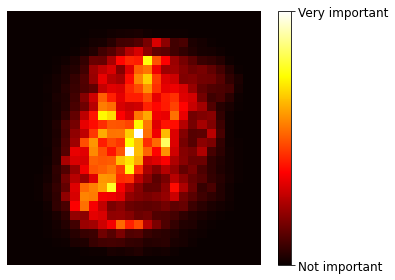

In [33]:
####################################################################################################
# 이 코드셀의 내용은 무시해도 됩니다.
####################################################################################################
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

 # Boosting (부스팅)

약한 학습기 여러 개를 (직렬로) 연결하여 강한 학습기를 만드는 앙상블 방법<br>
배깅이나 페이스팅처럼 병렬로 훈련할 수 없어 학습시간이 많이 소요되는 단점<br>

## AdaBoost (에이다부스트)

이전 분류기의 훈련 시 오분류된 샘플의 가중치를 상대적으로 높인 후 이후 분류기를 훈련하는 방식을 순차적으로 진행

Figure 7-7. AdaBoost sequential training with instance weight updates

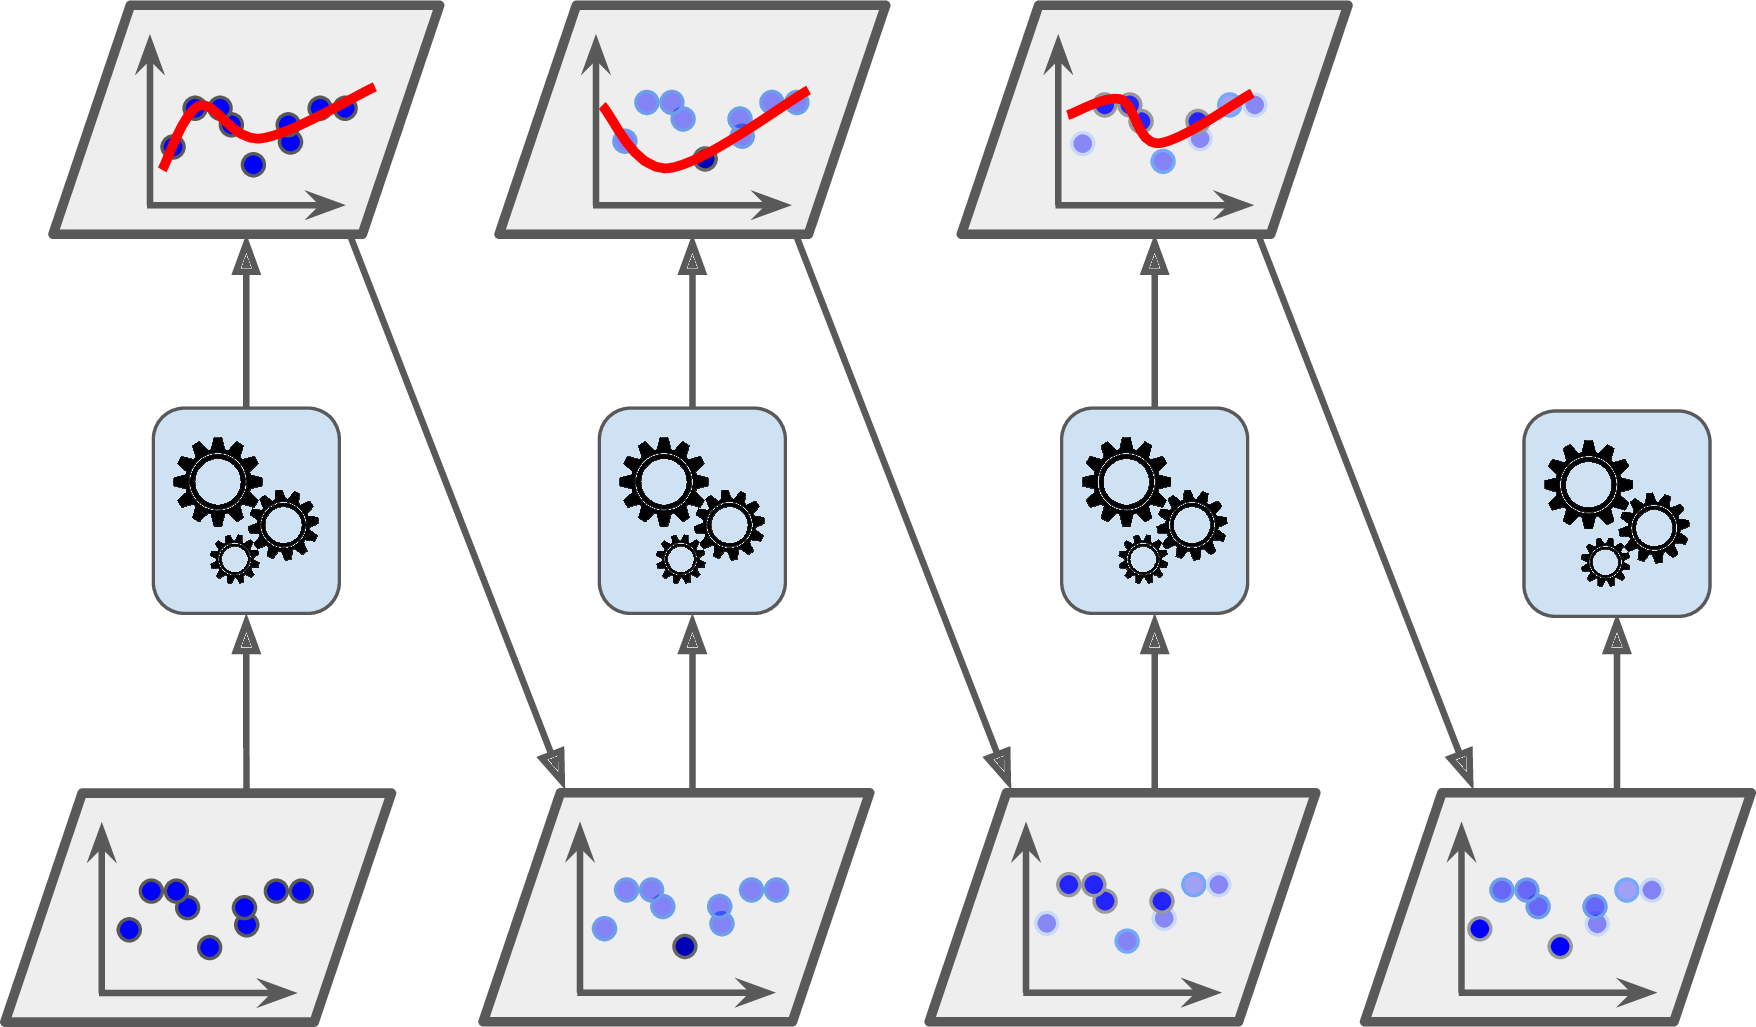

In [34]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

##### sklearn.ensemble.AdaBoostClassifier
class sklearn.ensemble.AdaBoostClassifier(base_estimator=None, *, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)<br>
An AdaBoost classifier.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboostclassifier<br>

In [35]:
####################################################################################################
# 학습된 모델로 결정경계를 그린다.
####################################################################################################plot_decision_boundary(ada_clf, X, y)

**Code to generate Figure 7–8. Decision boundaries of consecutive predictors:**

Saving figure boosting_plot


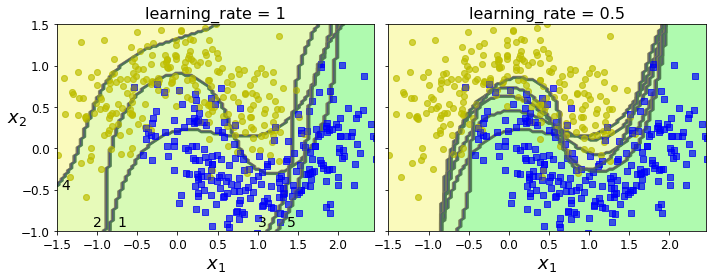

In [36]:
####################################################################################################
# 이 코드셀의 내용은 무시해도 됩니다.
####################################################################################################
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1. Weighted error rate of the jth predictor
        alpha = learning_rate * np.log((1 - r) / r)                        # equation 7-2. Predictor weight
        sample_weights[y_pred != y_train] *= np.exp(alpha)                 # equation 7-3. Weight update rule
        sample_weights /= sample_weights.sum()                             # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

Figure   7-8 shows the decision boundaries of five consecutive predictors on the moons dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel14). The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on. The plot on the right represents the same sequence of predictors, except that the learning rate is halved (i.e., the misclassified instance weights are boosted much less at every iteration). As you can see, this sequential learning technique has some similarities with Gradient Descent, except that instead of tweaking a single predictor’s parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better.

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (Kindle Locations 4271-4277). O'Reilly Media. Kindle Edition. 

## Gradient Boosting (그레이디언트 부스팅)

반복마다 샘플의 가중치를 수정하는 에이다부스트와는 달리 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습

Let's create a simple quadratic dataset:

In [37]:
####################################################################################################
# 학습 데이터셋 생성
####################################################################################################np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

Now let's train a decision tree regressor on this dataset:

In [38]:
####################################################################################################
# 의사결정나무 회귀 모델(1차) 생성 및 훈련: 이해를 위한 코드로서, 실제 구현용이 아님
# --------------------------------------------------------------------------------------------------
# 입력/타깃 데이터는 주어진 데이터셋 사용
####################################################################################################
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [39]:
####################################################################################################
# 의사결정나무 회귀 모델(2차) 생성 및 훈련: 이해를 위한 코드로서, 실제 구현용이 아님
# --------------------------------------------------------------------------------------------------
# 입력 데이터는 그대로. 타깃 데이터는 잔차 사용(y-1차 모델의 예측값)
####################################################################################################
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [40]:
####################################################################################################
# 의사결정나무 회귀 모델(3차) 생성 및 훈련: 이해를 위한 코드로서, 실제 구현용이 아님
# --------------------------------------------------------------------------------------------------
# 입력 데이터는 그대로. 타깃 데이터는 잔차 사용(y-1차 모델의 예측값-2차 모델의 예측값)
####################################################################################################
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [41]:
X_new = np.array([[0.8]])

In [42]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [43]:
y_pred

array([0.67548595])

**Code to generate Figure 7–9. In this depiction of Gradient Boosting, the first predictor (top left) is trained normally, then each consecutive predictor (middle left and lower left) is trained on the previous predictor’s residuals; the right column shows the resulting ensemble’s predictions:**

In [44]:
####################################################################################################
# 회귀 모형의 예측값을 plot하기 위한 사용자 정의 함수
# --------------------------------------------------------------------------------------------------
# 회귀 모형(regressor)와 이 분류기의 예측값을 표현할 영역(x, y축)을 전달하면 예측값을 표시
# * 코드를 모두 이해하실 필요는 없으며, 함수로 전달되는 매개변수와 이 함수의 수행결과를 연계하여 
#   함수가 수행하는 작업에 대해서만 이해하고, 추후에 코드를 재활용하실 수 있으면 됩니다.
####################################################################################################
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


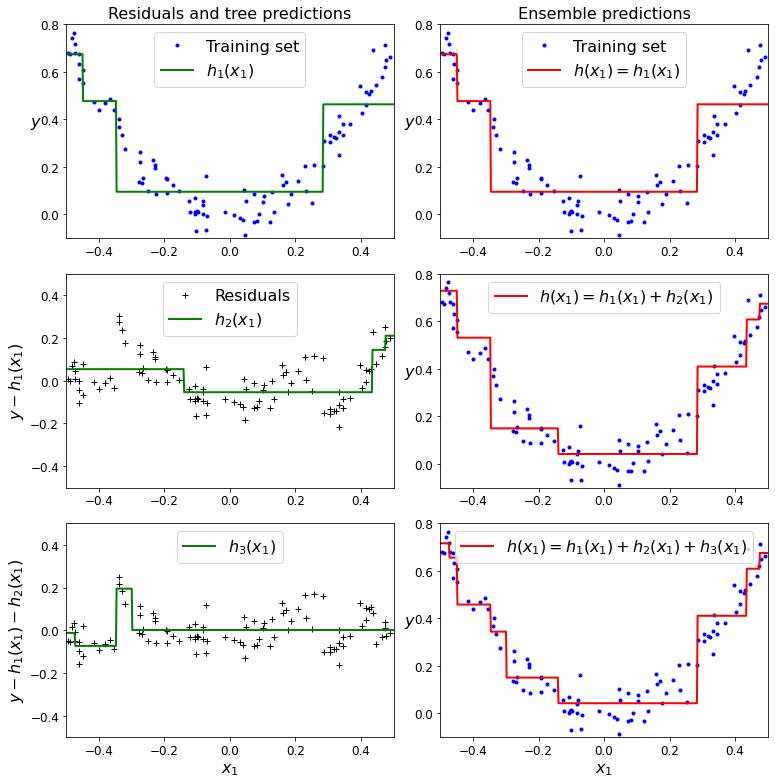

In [45]:
####################################################################################################
# 각 단계의 모델별로 예측값과 잔차를 보여주는 그래프를 그린다.
####################################################################################################
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

Now let's try a gradient boosting regressor:

In [46]:
####################################################################################################
# 그레이디언트 부스팅의 실제 구현 코드 (예측기를 너무 적게 포함하여 과소적합된 모델)
####################################################################################################
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

**Code to generate Figure 7–10. GBRT ensembles with not enough predictors (left) and too many (right):**

In [47]:
####################################################################################################
# 그레이디언트 부스팅의 실제 구현 코드 (예측기를 너무 많이 포함하여 과대적합된 모델)
####################################################################################################
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


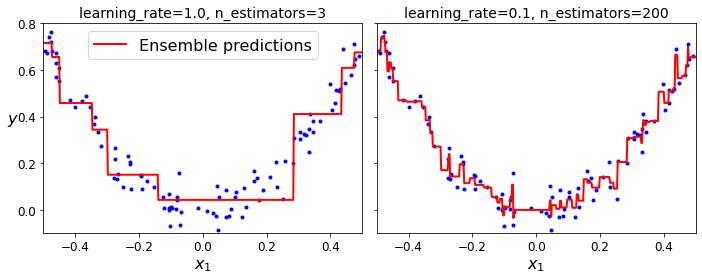

In [48]:
####################################################################################################
# 두 개의 그레이디언트 부스팅 모델을 비교
####################################################################################################
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

**Gradient Boosting with Early stopping:**

In [49]:
####################################################################################################
# 그레이디언트 부스팅의 실제 구현 코드1 (최적의 예측기 수를 찾기 위한 방법)
####################################################################################################
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1               # optimal number of trees whose sum of errors is the minimum

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=70, random_state=42)

In [50]:
####################################################################################################
# 가장 작은 에러가 발견되는 위치를 보여주기 위한 코드
####################################################################################################
print(np.argmin(errors))
for idx, error in enumerate(errors):
    print(idx, error)

69
0 0.05552189312648568
1 0.047992570306992714
2 0.04155804482360849
3 0.0361470421459409
4 0.031628917373626456
5 0.02774185583958195
6 0.024461656910873743
7 0.021651406434383444
8 0.01920098049572446
9 0.017310190766639536
10 0.015566734621405134
11 0.014312672305132551
12 0.013191732696760706
13 0.012222403479096844
14 0.01143241938807308
15 0.010678865914203466
16 0.009786082039981393
17 0.009134925842575642
18 0.008525155795623915
19 0.008121941549701982
20 0.00748737057701476
21 0.006867527451062259
22 0.00657576561121296
23 0.006264795653127113
24 0.006028315059333851
25 0.005669236810946835
26 0.005328459074654376
27 0.005158262582988142
28 0.004983355452268958
29 0.004774330857130853
30 0.004696296592260804
31 0.004418003041436439
32 0.0043250210804198505
33 0.004248240835857917
34 0.004182973899286938
35 0.004129788657057692
36 0.004059214053661332
37 0.0039901952105127455
38 0.003948347194065819
39 0.0039158392374032585
40 0.0038921126058378453
41 0.0038318907285558113
42 

**Code to generate Figure 7–11. Tuning the number of trees using early stopping:**

In [51]:
####################################################################################################
# 가장 작은 에러를 변수에 저장
####################################################################################################
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


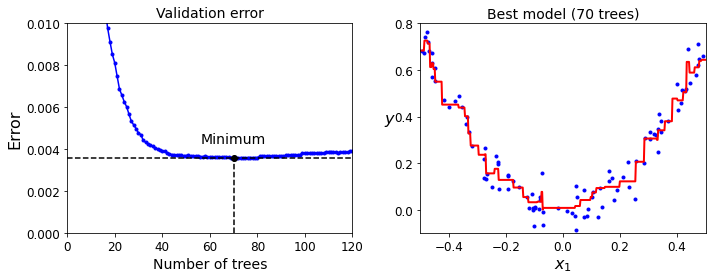

In [52]:
####################################################################################################
# 가장 작은 에러가 발견되는 트리 수와 그 때의 모델을 그래프로 보여주기 위한 코드
####################################################################################################
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

Early stopping with some patience (interrupts training only after there's no improvement for 5 epochs):

In [53]:
####################################################################################################
# 그레이디언트 부스팅의 실제 구현 코드2 (최적의 예측기 수를 찾으면 조기 종료하기 위한 방법)
####################################################################################################
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators               # 모델에 포함될 예측기의 갯수를 점차 증가시키며
    gbrt.fit(X_train, y_train)                     # 훈련하여
    y_pred = gbrt.predict(X_val)                   # 예측값을 구하고
    val_error = mean_squared_error(y_val, y_pred)  # 성능을 측정하여
    if val_error < min_val_error:                  # 에러가 감소(성능이 향상)되었으면
        min_val_error = val_error                  # 최소 에러값을 새로운 에러값으로 대체하고
        error_going_up = 0                         # 에러가 감소했으므로 에러가 증가한 횟수를 0으로 초기화
    else:                                          # 에러가 증가했으면(성능이 저하)
        error_going_up += 1                        # 에러 증가 횟수를 1 증가
        if error_going_up == 5:                    # 에러 증가 횟수가 5이면 (우연히 계속 증가하고 있다고 보기는 어렵다고 판단되는 횟수를 지정)
            break  # early stopping                # 훈련을 중단

In [54]:
####################################################################################################
# 훈련이 중단된 위치로부터 5번 이전이 최저 에러일 것이므로 이를 반영하여 최소 위치 확인
####################################################################################################
#print(gbrt.n_estimators)
print(gbrt.n_estimators - 5)    # the minum error reached 5 epochs earlier

70


In [55]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.003585589033111052


**Using XGBoost:**

In [56]:
####################################################################################################
# 이 코드셀의 내용은 무시해도 됩니다.
####################################################################################################
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [57]:
####################################################################################################
# 이 코드셀의 내용은 무시해도 됩니다.
####################################################################################################
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

Validation MSE: 0.004324534586857416


In [58]:
####################################################################################################
# 이 코드셀의 내용은 무시해도 됩니다.
####################################################################################################
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[0]	validation_0-rmse:0.26128
[1]	validation_0-rmse:0.19605
[2]	validation_0-rmse:0.15183
[3]	validation_0-rmse:0.12045
[4]	validation_0-rmse:0.09787
[5]	validation_0-rmse:0.08463
[6]	validation_0-rmse:0.07666
[7]	validation_0-rmse:0.07154
[8]	validation_0-rmse:0.06765
[9]	validation_0-rmse:0.06487
[10]	validation_0-rmse:0.06404
[11]	validation_0-rmse:0.06273
[12]	validation_0-rmse:0.06222
[13]	validation_0-rmse:0.06181
[14]	validation_0-rmse:0.06131
[15]	validation_0-rmse:0.06171
Validation MSE: 0.003758771069017904


In [59]:
####################################################################################################
# 이 코드셀의 내용은 무시해도 됩니다.
####################################################################################################
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

44.9 ms ± 2.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
####################################################################################################
# 이 코드셀의 내용은 무시해도 됩니다.
####################################################################################################
%timeit GradientBoostingRegressor().fit(X_train, y_train)

9.96 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Exercise solutions

## 1. to 7.

See Appendix A.

## 8. Voting Classifier

Exercise: _Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

The MNIST dataset was loaded earlier.

In [61]:
####################################################################################################
# mnist dataset을 mnist변수에 저장합니다.
####################################################################################################

# Write your code here.

In [62]:
####################################################################################################
# mnist dataset을 mnist변수에 저장합니다.
####################################################################################################
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [63]:
####################################################################################################
# mnist dataset(입력, 타깃)을 학습/검증/테스트 데이터셋으로 분할합니다.
# --------------------------------------------------------------------------------------------------
# 1차 분할: 전체 --> 학습+검증/테스트
# 2차 분할: 학습+검증 --> 학습/검증
####################################################################################################

# Write your code here.

In [64]:
####################################################################################################
# mnist dataset(입력, 타깃)을 학습/검증/테스트 데이터셋으로 분할합니다.
# --------------------------------------------------------------------------------------------------
# 1차 분할: 전체 --> 학습+검증/테스트
# 2차 분할: 학습+검증 --> 학습/검증
####################################################################################################
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [65]:
####################################################################################################
# 여러 분류기 클래스를 임포트 합니다.
####################################################################################################
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

In [66]:
####################################################################################################
# 분류기를 생성합니다.
####################################################################################################

# Write your code here.

In [67]:
####################################################################################################
# 분류기를 생성합니다.
####################################################################################################
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [68]:
####################################################################################################
# 분류기를 훈련합니다.
####################################################################################################

# Write your code here. 

In [69]:
####################################################################################################
# 분류기를 훈련합니다.
####################################################################################################
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)    

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [70]:
####################################################################################################
# 훈련된 분류기의 성능을 구합니다.
####################################################################################################

# Write your code here.

In [71]:
####################################################################################################
# 훈련된 분류기의 성능을 구합니다.
####################################################################################################
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9634]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: _Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [72]:
####################################################################################################
# 투표 분류기를 사용하기 위해 VotingClassifier 클래스를 임포트합니다.
####################################################################################################

# Write your code here.

In [73]:
####################################################################################################
# 투표 분류기를 사용하기 위해 VotingClassifier 클래스를 임포트합니다.
####################################################################################################
from sklearn.ensemble import VotingClassifier

In [74]:
####################################################################################################
# 개별 분류기를 리스트에 저장합니다.
####################################################################################################

# Write your code here.

In [75]:
####################################################################################################
# 개별 분류기를 리스트에 저장합니다.
####################################################################################################
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [76]:
####################################################################################################
# 저장된 리스트를 파라미터로 전달하며 직접 투표 분류기를 생성합니다.
####################################################################################################

# Write your code here.

In [77]:
####################################################################################################
# 저장된 리스트를 파라미터로 전달하며 직접 투표 분류기를 생성합니다.
####################################################################################################
voting_clf = VotingClassifier(named_estimators)

In [78]:
####################################################################################################
# 직접 투표 분류기를 훈련합니다.
####################################################################################################

# Write your code here.

In [79]:
####################################################################################################
# 직접 투표 분류기를 훈련합니다.
####################################################################################################
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [80]:
####################################################################################################
# 직접 투표 분류기의 성능을 확인합니다.

# Write your code here.

In [81]:
####################################################################################################
# 직접 투표 분류기의 성능을 확인합니다.
####################################################################################################
voting_clf.score(X_val, y_val)

0.9708

In [82]:
####################################################################################################
# 직접 투표 분류기에 속한 개별 분류기의 성능을 확인합니다.
####################################################################################################

# Write your code here.

In [83]:
####################################################################################################
# 직접 투표 분류기에 속한 개별 분류기의 성능을 확인합니다.
####################################################################################################
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859, 0.9634]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `None` using `set_params()` like this:

In [84]:
####################################################################################################
# 가장 성능이 낮은 분류기를 제거합니다.
# --------------------------------------------------------------------------------------------------
# 모델객체 파라미터에 None 값을 설정하면 됩니다.
####################################################################################################

# Write your code here.

In [85]:
####################################################################################################
# 가장 성능이 낮은 분류기를 제거합니다.
# --------------------------------------------------------------------------------------------------
# 모델객체 파라미터에 None 값을 설정하면 됩니다.
####################################################################################################
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

This updated the list of estimators:

In [86]:
####################################################################################################
# 분류기 목록을 확인합니다.
# --------------------------------------------------------------------------------------------------
# 제거 대상 모델객체의 파라미터에 None 값이 설정된 것을 확인하면 됩니다.
####################################################################################################

# Write your code here.

In [87]:
####################################################################################################
# 분류기 목록을 확인합니다.
# --------------------------------------------------------------------------------------------------
# 제거 대상 모델객체의 파라미터에 None 값이 설정된 것을 확인하면 됩니다.
####################################################################################################
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

However, it did not update the list of _trained_ estimators:

In [88]:
####################################################################################################
# 훈련된 분류기 목록을 확인합니다.
# --------------------------------------------------------------------------------------------------
# 제거 대상 모델객체의 파라미터에 None 값이 설정된 것을 확인하면 됩니다.
####################################################################################################

# Write your code here.

In [89]:
####################################################################################################
# 훈련된 분류기 목록을 확인합니다.
# --------------------------------------------------------------------------------------------------
# 제거 대상 모델객체의 파라미터에 None 값이 설정된 것을 확인하면 됩니다.
####################################################################################################
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators:

In [90]:
####################################################################################################
# 가장 성능이 낮은 분류기(학습된 예측기)를 제거합니다.
# --------------------------------------------------------------------------------------------------
# del 명령어를 사용합니다.
####################################################################################################

# Write your code here.

In [91]:
####################################################################################################
# 가장 성능이 낮은 분류기(학습된 예측기)를 제거합니다.
# --------------------------------------------------------------------------------------------------
# del 명령어를 사용합니다.
####################################################################################################
del voting_clf.estimators_[2]

Now let's evaluate the `VotingClassifier` again:

In [92]:
####################################################################################################
# 직접 투표 분류기의 성능을 확인합니다.
# --------------------------------------------------------------------------------------------------
# 제거 전보다 성능이 향상된 것을 확인합니다.
####################################################################################################

# Write your code here.

In [93]:
####################################################################################################
# 직접 투표 분류기의 성능을 확인합니다.
# --------------------------------------------------------------------------------------------------
# 제거 전보다 성능이 향상된 것을 확인합니다.
####################################################################################################
voting_clf.score(X_val, y_val)

0.9735

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [94]:
####################################################################################################
# 간접 투표 분류기를 사용하기 위해 voting 파라미터를 "soft"로 변경합니다.

# Write your code here.

In [95]:
####################################################################################################
# 간접 투표 분류기를 사용하기 위해 voting 파라미터를 "soft"로 변경합니다.
####################################################################################################
voting_clf.voting = "soft"

In [96]:
####################################################################################################
# 간접 투표 분류기의 성능을 확인합니다.
####################################################################################################

# Write your code here.

In [97]:
####################################################################################################
# 간접 투표 분류기의 성능을 확인합니다.
####################################################################################################
voting_clf.score(X_val, y_val)

0.9692

Nope, hard voting wins in this case.

_Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?_

In [98]:
####################################################################################################
# 직접 투표 분류기를 사용하기 위해 voting 파라미터를 "hard"로 변경한 후 성능을 확인합니다.
####################################################################################################

# Write your code here.

In [99]:
####################################################################################################
# 직접 투표 분류기를 사용하기 위해 voting 파라미터를 "hard"로 변경한 후 성능을 확인합니다.
####################################################################################################
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9705

In [100]:
####################################################################################################
# 직접 투표 분류기에 속한 개별 분류기의 성능을 확인합니다.
####################################################################################################

# Write your code here.

In [101]:
####################################################################################################
# 직접 투표 분류기에 속한 개별 분류기의 성능을 확인합니다.
####################################################################################################
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9611]

The voting classifier only very slightly reduced the error rate of the best model in this case.

## 9. Stacking Ensemble **

이 문제는 풀지 않으셔도 됩니다.

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [102]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [103]:
X_val_predictions.shape, X_val_predictions

((10000, 4),
 array([[5., 5., 5., 5.],
        [8., 8., 8., 8.],
        [2., 2., 3., 2.],
        ...,
        [7., 7., 7., 7.],
        [6., 6., 6., 6.],
        [7., 7., 7., 7.]], dtype=float32))

In [104]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [105]:
rnd_forest_blender.oob_score_

0.9698

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [106]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [107]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [108]:
from sklearn.metrics import accuracy_score

In [109]:
accuracy_score(y_test, y_pred)

0.9686

This stacking ensemble does not perform as well as the voting classifier we trained earlier, it's not quite as good as the best individual classifier.